In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

# Training, Validation, and Test Sets
In order to evaluate the performance of the different models, we split the data into training, validation, and test sets.  
The model is:
* first fit to the training data
* hyperparameters are tuned using the validation set (some techniques include k-folds cross validation in the training, so validation set is not necessary for all models)
* final model performance is evaluated on the test set

<br/>
### Additional Considerations for Geo-Spatial Data
In many applications, the validation and test sets are chosen randomly from the data.  However, because of temporal and spatial autocorrelation, this may not be appropriate for geo-spatial or time-series data.  

The code here will allow for 3 types of data-splitting:
* **Random:** Test and validation sets chosen at random (each raster cell has equal probability of being in training/test/validation set).
* **Internal Block:** The validation and test sets will be drawn from (approximately) square blocks within the raster region.
* **Edge Block:** The test and validation set will be taken from the border region of any specified side of the raster.  (This will test how well the model can be applied to regions _outside_ of the region on which the model was trained.

In all _regimes_, the data will first be split into [`training`, `validation_and_test`], according to the method chosen, and then `validation_and_test` will be further divided random into [`validation`, `test`] using the same method.

In [2]:
# Make some fake data to test with
cell_dim = 10000
x_vals = cell_dim * np.linspace(1, 100, num=100)
y_vals = cell_dim * np.linspace(1, 100, num=100)
xy = np.transpose([np.tile(x_vals, len(y_vals)), 
                   np.repeat(y_vals, len(x_vals))])
response = np.random.rand(xy.shape[0])

data = pd.DataFrame(data=xy, index=range(xy.shape[0]), columns=['x', 'y'])
data['response'] = response

print('Data set: (%d rows x %d columns)' % (data.shape[0], data.shape[1]))
data.head()

Data set: (10000 rows x 3 columns)


,x,y,response
0,10000.0,10000.0,0.698084
1,20000.0,10000.0,0.611901
2,30000.0,10000.0,0.804022
3,40000.0,10000.0,0.269833
4,50000.0,10000.0,0.941252


In [3]:
def print_ranges(data):
    print(' x range: [%s, %s]\ty range: [%s, %s]' 
          % (data.x.min(), data.x.max(), data.y.min(), data.y.max()))

In [4]:
def print_data_split(X_train, y_train, X_valid, y_valid, X_test, y_test):
    '''
    Prints dimensions of train, validation, and test data and response 
    variables, neatly formatted.
    
    Args: (All): DataFrame: the raw data for each of the sets
    Returns: None
    '''
    print('Data split into:\n X_train: %s  y_train: %s' 
          % (X_train.shape, y_train.shape))
    print_ranges(X_train)
    print('\n X_valid: %s  y_valid: %s' % (X_valid.shape, y_valid.shape))
    print_ranges(X_valid)
    print('\n X_test:  %s  y_test:  %s' % (X_test.shape, y_test.shape)) 
    print_ranges(X_test)

In [5]:
def convert_data_to_0_base(data):
    data.x = ((data.x - min(data.x)) / cell_dim).astype(int)
    data.y = ((data.y - min(data.y)) / cell_dim).astype(int)
    return data

In [6]:
def split_data_random(dat, resp, proportions, cell_dim):
    '''
    Not intended to be called directly; will be called by split_data().
    See split_data() for documentation.
    '''
    data = dat.copy()
    response = resp.copy()
    train, valid, test = proportions    
    data = convert_data_to_0_base(data)
    
    # Split data into [train, validation_and_test]
    X_train, X_vt, y_train, y_vt = train_test_split(
        data, response, test_size=valid + test)

    # Split validation_and_test into [validation, test]
    X_valid, X_test, y_valid, y_test = train_test_split(
        X_vt, y_vt, test_size=(test / (test + valid)))
    
    print_data_split(X_train, y_train, X_valid, y_valid, X_test, y_test)
    return [[X_train, y_train], [X_valid, y_valid], [X_test, y_test]]

In [7]:
def get_proportional_internal_block(height, width, proportion, vis=False):
    n = height * width
    n_block = int(round(n * proportion))
    scaler = np.sqrt(n_block / (height * width))
    h_block = int(round(height * scaler))
    w_block = int(round(width * scaler))
    x_offset = (width - w_block) // 2
    y_offset = (height - h_block) // 2
    deficit = n_block - (h_block * w_block)
    x_range = [x_offset, x_offset + w_block]
    y_range = [y_offset, y_offset + h_block]
    
    if vis:
        plt.plot(
            [0, width, width, 0, 0], 
            [0, 0, height, height, 0], 
            label='Full Data Set');
        plt.plot(
            [x_offset, x_offset + w_block, x_offset + w_block, x_offset, 
             x_offset],
            [y_offset, y_offset, y_offset + h_block, y_offset + h_block, 
             y_offset],
            label='Subset');
        plt.xrange = [-100, width + 100]
        plt.yrange = [-100, height + 100]
        plt.legend(loc='best');
        
    return {'x_range': x_range, 'y_range': y_range, 'deficit': deficit}

{'deficit': 317, 'x_range': [1105, 2894], 'y_range': [276, 723]}

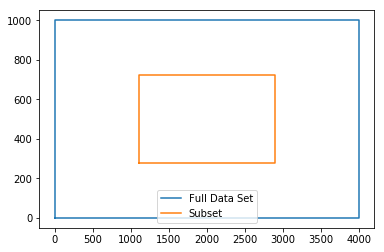

In [8]:
get_proportional_internal_block(1000, 4000, 0.2, vis=True)

{'deficit': 2080, 'x_range': [184, 816], 'y_range': [1470, 6530]}

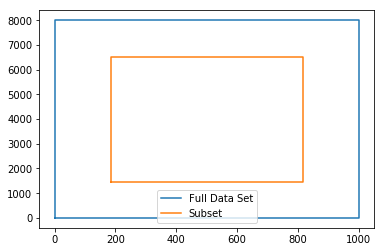

In [9]:
get_proportional_internal_block(8000, 1000, 0.4, vis=True)

In [10]:
def split_data_by_xy_ranges(dat, x_range, y_range):
    data = dat.copy()
    inner_data = data.loc[((data.x >= x_range[0]) &
                           (data.x <  x_range[1]) &
                           (data.y >= y_range[0]) &
                           (data.y <  y_range[1])), :]
    outer_data = data.loc[((data.x <  x_range[0]) |
                           (data.x >= x_range[1]) |
                           (data.y <  y_range[0]) |
                           (data.y >= y_range[1])), :]
    return inner_data, outer_data

In [11]:
def split_predictors_response(dat, response):
    data = dat.copy()
    y = data[response]
    X = data.drop(response, axis=1)
    return X, y

In [12]:
def split_data_internal(dat, response, proportions, cell_dim):
    '''
    Not intended to be called directly; will be called by split_data().
    See split_data() for documentation.
    '''
    data = dat.copy()
    train, valid, test = proportions
    n = data.shape[0]
    n_train = int(round(n * proportions[0]))
    n_valid = int(round(n * proportions[1]))
    n_test = n - n_train - n_valid
    data = convert_data_to_0_base(data)    
    test_valid_box = get_proportional_internal_block(
        width=data.x.max(), height=data.y.max(), proportion=valid + test)

    x_offset = test_valid_box['x_range'][0]
    y_offset = test_valid_box['y_range'][0]
    
    test_box = get_proportional_internal_block(
        width=test_valid_box['x_range'][1] - test_valid_box['x_range'][0],
        height=test_valid_box['y_range'][1] - test_valid_box['y_range'][0],
        proportion=test / (test + valid))
    
    test_box['x_range'] += x_offset
    test_box['y_range'] += y_offset
    
    test_set, tv_set = split_data_by_xy_ranges(
        data, test_box['x_range'], test_box['y_range'])
    valid_set, train_set = split_data_by_xy_ranges(
        tv_set, test_valid_box['x_range'], test_valid_box['y_range'])
    
    X_train, y_train = split_predictors_response(train_set, response)
    X_valid, y_valid = split_predictors_response(valid_set, response)
    X_test,  y_test  = split_predictors_response(test_set,  response)

    print_data_split(X_train, y_train, X_valid, y_valid, X_test, y_test)
    return [[X_train, y_train], [X_valid, y_valid], [X_test, y_test]]

In [13]:
def get_edge_data(dat, n_cells, side):
    data = dat.copy()
    cells_in_set = 0
    next_row = 0

    order = ['x', 'y'] if side in ['e', 'w'] else ['y', 'x']
    ascending = [True, True] if side in ['n', 'w'] else [False, False]
    data = data.sort_values(order, ascending=ascending)
        
    while cells_in_set < n_cells:
        subset = data.iloc[:next_row, :]
        cells_in_set = subset.shape[0]
        next_row += 1

    n_subset = subset.shape[0]
    subset_less_one_row = data.iloc[:(next_row - 1), :]
    n_subset_less_one = subset_less_one_row.shape[0]
    subset_diff = np.abs(n_subset - n_cells)
    subset_less_one_diff = np.abs(n_subset_less_one - n_cells)

    return (subset if subset_diff < subset_less_one_diff 
            else subset_less_one_row)

In [14]:
def remove_subset(combined_set, subset, side):
    ref = 'y' if side in ['n', 's'] else 'x'
    subset_min, subset_max = subset[ref].min(), subset[ref].max()
    other_set = combined_set.loc[((combined_set[ref] < subset_min) |
                                  (combined_set[ref] > subset_max)), :]
    return other_set

In [15]:
def split_data_edge(dat, response, proportions, cell_dim, side):
    data = dat.copy()
    train, valid, test = proportions
    n = data.shape[0]
    n_train = int(round(n * proportions[0]))
    n_valid = int(round(n * proportions[1]))
    n_test = n - n_train - n_valid
    data = convert_data_to_0_base(data)
    vt_set = get_edge_data(data, n_test + n_valid, side)
    test_set = get_edge_data(vt_set, n_test, side)
    valid_set = remove_subset(vt_set, test_set, side)
    train_set = remove_subset(data, vt_set, side)
                
    X_train, y_train = split_predictors_response(train_set, response)
    X_valid, y_valid = split_predictors_response(valid_set, response)
    X_test,  y_test  = split_predictors_response(test_set,  response)

    print_data_split(X_train, y_train, X_valid, y_valid, X_test, y_test)
    return [[X_train, y_train], [X_valid, y_valid], [X_test, y_test]]

In [16]:
def split_data(dat, 
               response, 
               method, 
               cell_dim, 
               proportions=[0.7, 0.15, 0.15], 
               side=None):
    '''
    Split the data in <data> into test, validation, and test sets.
    
    Args:
        data: DataFrame: the input data
        response: string: name of column containing the response variable
        method: string: 'random', 'internal' or 'edge'
        cell_dim: numeric: dimension of raster cells
        proportions: list of length 3: specifies the proportion of the
            data to be used in each set: [training, validation, test]
        side: string: If <method> is 'edge', specify the edge as 
            n', 's', 'e', or 'w'; for other methods side=None.
    Returns:
        list: [[X_train, y_train], [X_valid, y_valid], [X_test, y_test]]
    '''
    data = dat.copy()
    proportions = np.array(proportions) # convert type
    
    assert len(proportions) == 3 and proportions.sum() == 1.
    assert method in ['random', 'internal', 'edge']        
                
    if method == 'random':
        # Split data into X and y 
        X, y = split_predictors_response(data, response)
        return split_data_random(X, y, proportions, cell_dim)
    if method == 'internal':
        assert cell_dim is not None
        # TODO: Add offset so different windows can be extracted 
        return split_data_internal(data, response, proportions, cell_dim)
    if method == 'edge':
        assert side in ['n', 's', 'e', 'w']
        return split_data_edge(data, response, proportions, cell_dim, side)

In [17]:
# Test
[[X_train, y_train], [X_valid, y_valid], [X_test, y_test]] = split_data(
    data, 
    'response', 
    'random', 
    cell_dim=10000, 
    proportions=[0.8, 0.1, 0.1])

Data split into:
 X_train: (8000, 2)  y_train: (8000,)
 x range: [0, 99]	y range: [0, 99]

 X_valid: (1000, 2)  y_valid: (1000,)
 x range: [0, 99]	y range: [0, 99]

 X_test:  (1000, 2)  y_test:  (1000,)
 x range: [0, 99]	y range: [0, 99]


In [18]:
[[X_train, y_train], [X_valid, y_valid], [X_test, y_test]] = split_data(
    data, 
    'response', 
    'internal', 
    cell_dim=10000, 
    proportions=[0.8, 0.1, 0.1])

Data split into:
 X_train: (8064, 2)  y_train: (8064,)
 x range: [0, 99]	y range: [0, 99]

 X_valid: (975, 2)  y_valid: (975,)
 x range: [27, 70]	y range: [27, 70]

 X_test:  (961, 2)  y_test:  (961,)
 x range: [33, 63]	y range: [33, 63]


In [19]:
[[X_train, y_train], [X_valid, y_valid], [X_test, y_test]] = split_data(
    data, 
    'response', 
    'edge', 
    cell_dim=10000,
    proportions=[0.8, 0.1, 0.1],  
    side='e')

Data split into:
 X_train: (8000, 2)  y_train: (8000,)
 x range: [0, 79]	y range: [0, 99]

 X_valid: (1000, 2)  y_valid: (1000,)
 x range: [80, 89]	y range: [0, 99]

 X_test:  (1000, 2)  y_test:  (1000,)
 x range: [90, 99]	y range: [0, 99]
